# NB10 — 256 Control Cells: Does More Cell Context Strengthen the Signal?

**Motivation**: NB09 used 64 control cells passed through the transformer as a sequence of 64 tokens. The Jacobian ∂Y/∂pert_repr is computed as the sensitivity of the mean output across those 64 cells. With only 64 cells, the transformer has limited cell-state context and the mean output estimate is noisy.

**This notebook**: rerun with **256 control cells** (same seed=42, first 256 from the 4,976 available). The transformer now attends over 256 cell-state tokens simultaneously — meaningfully different from just using a more accurate mean, since attention is operating over a richer cell-state distribution.

**Key comparison** (same random-stratified KDs from NB09, seed=99):

| Cells | Spearman pert-repr | Spearman one-hot |
|---|---|---|
| 64 (NB09) | 0.078 | 0.145 |
| 256 (NB10) | ? | ? |


In [1]:

lines = [
"import sys, pickle, time",
"import warnings; warnings.filterwarnings('ignore')",
"sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')",
"import torch, numpy as np, pandas as pd, anndata as ad",
"from state.tx.models.state_transition import StateTransitionPerturbationModel",
"from sklearn.metrics.pairwise import cosine_similarity",
"from scipy.stats import pearsonr, spearmanr, sem, mannwhitneyu",
"import matplotlib; matplotlib.use('Agg')",
"import matplotlib.pyplot as plt",
"",
"OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'",
"BASE   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2'",
"DATA   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/Replogle-Nadig-Preprint'",
"N_CELLS = 256",
"",
"print(f'=== NB10: {N_CELLS} Control Cells ===')",
"print(f'Torch: {torch.__version__}, CUDA: {torch.cuda.is_available()}')",
"",
"# ── Load model ────────────────────────────────────────────────────────────────",
"print('[1] Loading fewshot model...')",
"model = StateTransitionPerturbationModel.load_from_checkpoint(",
"    f'{BASE}/checkpoints/best.ckpt',",
"    map_location='cuda' if torch.cuda.is_available() else 'cpu'",
")",
"model.eval()",
"device = next(model.parameters()).device",
"var_dims   = pickle.load(open(f'{BASE}/var_dims.pkl', 'rb'))",
"pert_map   = {str(k): v for k, v in torch.load(f'{BASE}/pert_onehot_map.pt', weights_only=False).items()}",
"W = model.pert_encoder[0].weight.detach().cpu().numpy()",
"print(f'  Model on {device}')",
"",
"# ── 256 control cells (seed=42, same pool as NB09) ────────────────────────────",
"print(f'[2] Loading {N_CELLS} HepG2 control cells...')",
"adata     = ad.read_h5ad(f'{DATA}/replogle_matched_hvg.h5ad')",
"ctrl_mask = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'] == 'non-targeting')",
"ctrl_mat  = adata[ctrl_mask].obsm['X_hvg']",
"if hasattr(ctrl_mat, 'toarray'): ctrl_mat = ctrl_mat.toarray()",
"np.random.seed(42)",
"idx = np.random.choice(len(ctrl_mat), size=N_CELLS, replace=False)",
"ctrl_cells = torch.tensor(ctrl_mat[idx], dtype=torch.float32).to(device)",
"print(f'  ctrl_cells: {ctrl_cells.shape}')",
"",
"# ── Forward pass + Jacobian (identical structure to NB05/NB09) ───────────────",
"def forward_from_pert_repr(pert_repr_1d):",
"    S = ctrl_cells.shape[0]",
"    basal_enc = model.basal_encoder(ctrl_cells)",
"    pert_exp  = pert_repr_1d.unsqueeze(0).expand(S, -1)",
"    combined  = basal_enc + pert_exp",
"    if hasattr(model, 'batch_encoder') and model.batch_encoder is not None:",
"        bi = torch.zeros(S, dtype=torch.long, device=device)",
"        combined = combined + model.batch_encoder(bi)",
"    out = model.transformer_backbone(inputs_embeds=combined.unsqueeze(0))",
"    res = out.last_hidden_state.squeeze(0)",
"    return model.relu(model.project_out(res)).mean(0)",
"",
"def compute_jacobian(kd_name):",
"    oh = pert_map[kd_name].float().to(device)",
"    with torch.no_grad():",
"        pr = model.pert_encoder(oh.unsqueeze(0)).squeeze(0)",
"    J = torch.autograd.functional.jacobian(",
"        forward_from_pert_repr, pr, vectorize=True, create_graph=False)",
"    return J.detach().cpu().numpy()",
"",
"# ── Same random-stratified KDs as NB09 (seed=99) ─────────────────────────────",
"print('[3] Loading NB09 random-stratified KD list...')",
"with open(f'{OUTDIR}/nb09_jacobian_kd_names.pkl', 'rb') as f:",
"    kd_names = pickle.load(f)",
"print(f'  KDs: {len(kd_names)}')",
"",
"# ── Compute Jacobians ─────────────────────────────────────────────────────────",
"print(f'[4] Computing Jacobians for {len(kd_names)} KDs with {N_CELLS} cells...')",
"print('  (timing first KD to estimate total...)')",
"jacobians, failed = {}, []",
"t_start = time.time()",
"for i, kd in enumerate(kd_names):",
"    t0 = time.time()",
"    try:",
"        jacobians[kd] = compute_jacobian(kd)",
"    except Exception as e:",
"        failed.append((kd, str(e)))",
"    if i == 0:",
"        dt1 = time.time() - t0",
"        print(f'  First KD: {dt1:.1f}s -> estimated total: {dt1*len(kd_names)/60:.1f} min')",
"    if (i+1) % 25 == 0:",
"        elapsed = time.time() - t_start",
"        rate = (i+1) / elapsed",
"        eta  = (len(kd_names) - (i+1)) / rate / 60",
"        print(f'  {i+1}/{len(kd_names)}, {len(failed)} failed, {rate:.2f}/s, ETA {eta:.1f} min')",
"print(f'  Done: {len(jacobians)} computed, {len(failed)} failed')",
"",
"jac_mat = np.stack([jacobians[k] for k in kd_names if k in jacobians])",
"jac_oh  = jac_mat @ W",
"np.save(f'{OUTDIR}/nb10_jacobians.npy', jac_mat)",
"print(f'  Saved jac_mat {jac_mat.shape}')",
"",
"# ── Pairwise similarities ─────────────────────────────────────────────────────",
"print('[5] Pairwise cosine similarities...')",
"clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)",
"dy5       = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')",
"n   = len(kd_names)",
"idx_pairs = np.triu_indices(n, k=1)",
"ii, jj    = idx_pairs",
"",
"js_pr = cosine_similarity(jac_mat.reshape(n,-1).astype(np.float32))[idx_pairs]",
"js_oh = cosine_similarity(jac_oh.reshape(n,-1).astype(np.float32))[idx_pairs]",
"dy_s  = cosine_similarity(dy5.reindex(kd_names).values.astype(np.float32))[idx_pairs]",
"clust = clusters5['cluster'].reindex(kd_names)",
"same  = (clust.values[ii] == clust.values[jj])",
"",
"def rs(j,d): return pearsonr(j,d)[0], spearmanr(j,d)[0]",
"pr_pr,sr_pr = rs(js_pr, dy_s)",
"pr_oh,sr_oh = rs(js_oh, dy_s)",
"",
"# NB09 reference (same KDs, 64 cells)",
"sr_nb09_pr, sr_nb09_oh = 0.078, 0.145",
"print(f'  NB10 pert-repr: Pearson={pr_pr:.3f}, Spearman={sr_pr:.3f}  (NB09 64-cell: {sr_nb09_pr:.3f})')",
"print(f'  NB10 one-hot:   Pearson={pr_oh:.3f}, Spearman={sr_oh:.3f}  (NB09 64-cell: {sr_nb09_oh:.3f})')",
"for lab,js in [('pert-repr',js_pr),('one-hot',js_oh)]:",
"    s=js[same]; d=js[~same]",
"    _,p=mannwhitneyu(s,d,alternative='greater')",
"    print(f'  {lab}: same/diff={s.mean()/d.mean():.2f}x (p={p:.2e})')",
"",
"# ── Decile binning ────────────────────────────────────────────────────────────",
"N_BINS=10",
"def decile_means(dy_sims,jac_sims,n_bins=N_BINS):",
"    rj=np.argsort(np.argsort(jac_sims))/len(jac_sims)",
"    edges=np.percentile(dy_sims,np.linspace(0,100,n_bins+1)); edges[-1]+=1e-9",
"    labs=np.clip(np.digitize(dy_sims,edges)-1,0,n_bins-1)",
"    c,m,e=[],[],[]",
"    for b in range(n_bins):",
"        mask=labs==b; vals=rj[mask]",
"        c.append(dy_sims[mask].mean()); m.append(vals.mean()); e.append(sem(vals))",
"    return np.array(c),np.array(m),np.array(e)",
"",
"c_pr,m_pr,e_pr = decile_means(dy_s,js_pr)",
"c_oh,m_oh,e_oh = decile_means(dy_s,js_oh)",
"",
"# NB09 reference decile data",
"jac9 = np.load(f'{OUTDIR}/nb09_jacobians.npy')",
"n9=len(kd_names); idx9=np.triu_indices(n9,k=1)",
"dy9r=cosine_similarity(dy5.reindex(kd_names).values.astype(np.float32))[idx9]",
"js9_pr=cosine_similarity(jac9.reshape(n9,-1).astype(np.float32))[idx9]",
"js9_oh=cosine_similarity((jac9@W).reshape(n9,-1).astype(np.float32))[idx9]",
"c9_pr,m9_pr,e9_pr=decile_means(dy9r,js9_pr)",
"c9_oh,m9_oh,e9_oh=decile_means(dy9r,js9_oh)",
"",
"# ── Figure ────────────────────────────────────────────────────────────────────",
"C_64_PR='#93C5FD'; C_64_OH='#2563EB'",
"C_256_PR='#FCA5A5'; C_256_OH='#DC2626'",
"",
"fig,axes=plt.subplots(1,2,figsize=(14,6))",
"fig.suptitle(f'64 vs {N_CELLS} Control Cells  —  Same Random-Stratified KDs (NB09 vs NB10)',",
"             fontsize=13,fontweight='bold',y=1.02)",
"",
"ax=axes[0]",
"labels_b=['64-cell\\npert-repr','64-cell\\none-hot',f'{N_CELLS}-cell\\npert-repr',f'{N_CELLS}-cell\\none-hot']",
"p_vals=[0.083,0.172,pr_pr,pr_oh]",
"s_vals=[sr_nb09_pr,sr_nb09_oh,sr_pr,sr_oh]",
"colors=[C_64_PR,C_64_OH,C_256_PR,C_256_OH]",
"x=np.array([0,1]); w=0.18; offsets=[-1.5*w,-0.5*w,0.5*w,1.5*w]",
"for i,(lab,pv,sv,col) in enumerate(zip(labels_b,p_vals,s_vals,colors)):",
"    ax.bar(x[0]+offsets[i],pv,w,color=col,alpha=0.9,label=lab)",
"    ax.bar(x[1]+offsets[i],sv,w,color=col,alpha=0.9)",
"    for xp,v in [(x[0]+offsets[i],pv),(x[1]+offsets[i],sv)]:",
"        ax.text(xp,v+(0.004 if v>=0 else -0.006),f'{v:.3f}',ha='center',",
"                va='bottom' if v>=0 else 'top',fontsize=7.5,fontweight='bold',color=col)",
"ax.axhline(0,color='black',lw=0.8)",
"ax.set_xticks(x); ax.set_xticklabels(['Pearson r','Spearman r'],fontsize=12)",
"ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)',fontsize=10)",
"ax.set_ylim(-0.05,0.27); ax.legend(fontsize=8,ncol=2,loc='upper left')",
"ax.grid(axis='y',alpha=0.3,lw=0.5)",
"ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)",
"ax.set_title('A   64 vs 256 cells',fontsize=11,loc='left',fontweight='bold')",
"",
"ax2=axes[1]",
"ax2.errorbar(c9_pr,m9_pr,yerr=e9_pr,color=C_64_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'64-cell pert-repr r={sr_nb09_pr:.3f}',zorder=3)",
"ax2.errorbar(c9_oh,m9_oh,yerr=e9_oh,color=C_64_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'64-cell one-hot r={sr_nb09_oh:.3f}',zorder=4)",
"ax2.errorbar(c_pr,m_pr,yerr=e_pr,color=C_256_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'{N_CELLS}-cell pert-repr r={sr_pr:.3f}',zorder=3)",
"ax2.errorbar(c_oh,m_oh,yerr=e_oh,color=C_256_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'{N_CELLS}-cell one-hot r={sr_oh:.3f}',zorder=4)",
"ax2.axhline(0.5,color='gray',lw=1.2,linestyle=':',alpha=0.6,label='Flat')",
"ax2.set_xlabel('ΔY cosine similarity (binned into deciles)',fontsize=10)",
"ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1)',fontsize=10)",
"ax2.set_title('B   Decile-binned mean Jacobian rank',fontsize=11,loc='left',fontweight='bold')",
"ax2.legend(fontsize=8.5); ax2.grid(alpha=0.3,lw=0.5)",
"ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)",
"",
"plt.tight_layout()",
"fig.savefig(f'{OUTDIR}/nb10_256cells.png',dpi=150,bbox_inches='tight')",
"print('Saved nb10_256cells.png')",
]

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb10_run.py', 'w') as fh:
    fh.write('\n'.join(lines))
print("Written.")


Written.


In [2]:

import subprocess

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb10_run.py'],
    capture_output=True, text=True, timeout=3600
)
print(result.stdout[-3000:])
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


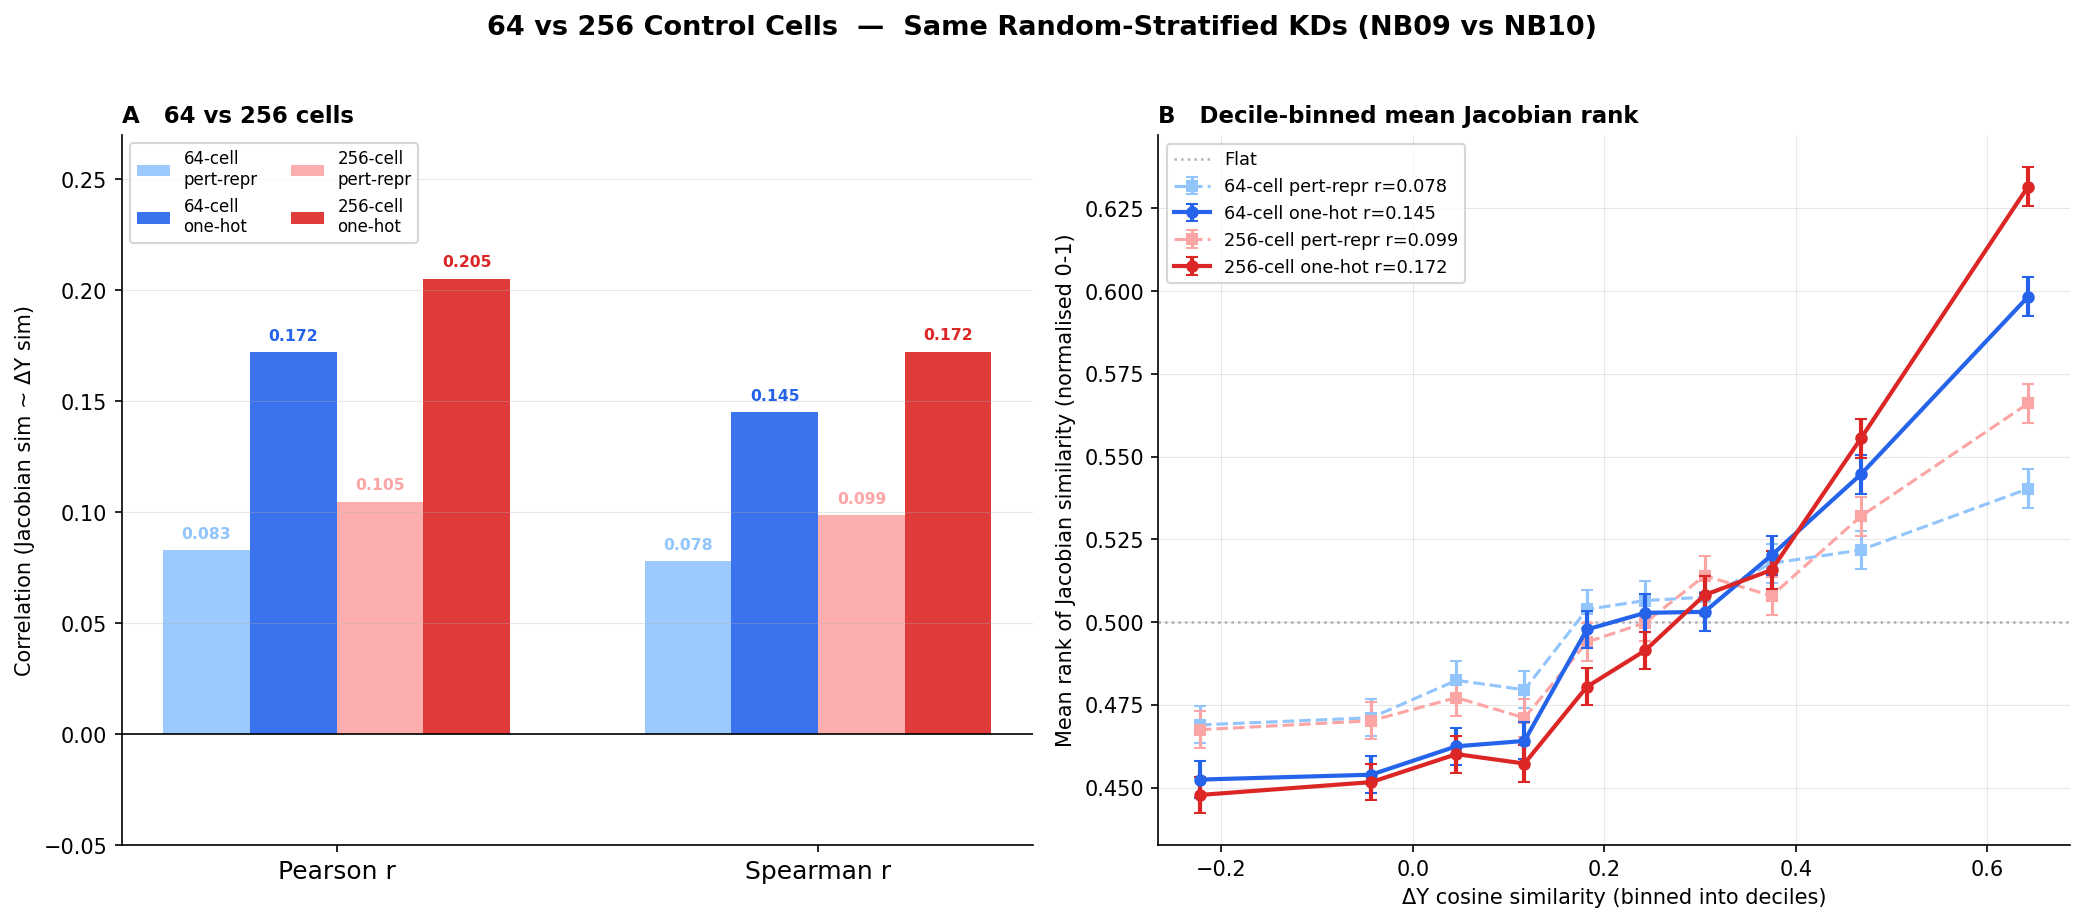

In [3]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb10_256cells.png', width=1100))


In [4]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-19-14_nb10_256cells_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb10_256cells_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")
